In [1]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import nlsa.kernels as knl
import nlsa.jax.vector_algebra as vec
import os
import time
from functools import partial
from ipywidgets import fixed, interact, IntSlider
from jax import Array, grad, jit, jvp, vmap
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import FromScalarField, ldivide_by, multiply_by
from nlsa.function_algebra2 import compose, compose2, BivariateFunctionSpace
from nlsa.jax.dynamics import make_rotation_vector_field
from nlsa.jax.vector_algebra import MeasureFnAlgebra, ScalarField,\
    VectorAlgebra
from nlsa.utils import swap_args
from numpy.typing import NDArray
from scipy.sparse.linalg import LinearOperator, eigs, eigsh
from typing import Callable, Literal, TypeVar

In [3]:
IDX_CPU = None
IDX_GPU = None
XLA_MEM_FRACTION = '.9'
F64 = False
SAVE_FIGS = False

if IDX_CPU is None and XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

match IDX_CPU, IDX_GPU:
    case int(IDX_CPU), None:
        jax.config.update("jax_default_device", jax.devices("cpu")[IDX_CPU])
    case None, int(IDX_GPU):    
        jax.config.update("jax_default_device", jax.devices("gpu")[IDX_GPU])

if F64:
    jax.config.update("jax_enable_x64", True)
    r_dtype = jnp.float64
    c_dtype = jnp.complex128
else:
    r_dtype = jnp.float32
    c_dtype = jnp.complex64

In [4]:
jvmap = compose(jit, vmap)
vvmap = compose(vmap, vmap)
jvvmap = compose(jit, vvmap)

In [5]:
N = Literal[32]
M = Literal[8]

R = Array
Rm = Array
T2 = Array
T2n = Array
X = Array
Xn = Array
V = Array
Vm = Array
W = Array
K = jnp.float32

S = TypeVar('S')
T = TypeVar('T')
F = Callable[[S], T]

Alpha = Literal['0', '0.5', '1']

In [6]:
alphas = jnp.array([1., jnp.sqrt(30)])

def embed_r4(theta: T2) -> X:
    """Embed points in the 2-torus into R4."""
    return jnp.array([jnp.cos(theta[0]), jnp.sin(theta[0]),
                      jnp.cos(theta[1]), jnp.sin(theta[1])])

v = make_rotation_vector_field(alphas)

In [7]:
n_grd = 32
n = n_grd ** 2

thetas_grd = jnp.linspace(0., 2.*jnp.pi, n_grd, endpoint=False)
theta1s, theta2s = jnp.meshgrid(thetas_grd, thetas_grd)
thetas: T2n = jnp.concatenate((theta1s[:, :, jnp.newaxis],
                               theta2s[:, :, jnp.newaxis]), 
                              axis=2)
theta1s = theta1s / jnp.pi
theta2s = theta2s / jnp.pi
xs: Xn = thetas.reshape(n, 2)
#xs: Xn = embed_r4(thetas).reshape(n, 4)

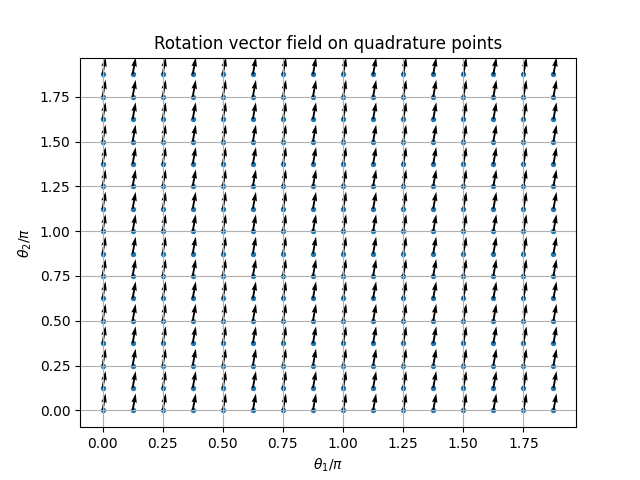

In [8]:
n_skip = 2
i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_vec(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_vec(figspecs):
    theta1s_plt = theta1s[::n_skip, ::n_skip]
    theta2s_plt = theta2s[::n_skip, ::n_skip]
    vs_plt = jvvmap(v)(thetas[::n_skip, ::n_skip, :])
    fig, ax = figspecs    
    ax.scatter(theta1s_plt, theta2s_plt, s=8)
    ax.quiver(theta1s_plt, theta2s_plt, vs_plt[:, :, 0], vs_plt[:, :, 1])
    ax.grid()
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title('Rotation vector field on quadrature points');


plotfig_vec(initfig_vec(i_fig))

In [9]:
scl = ScalarField(dtype=r_dtype)
inclusion_map: Callable[[F[X, R]], V] = vec.veval_at(xs)
ell2: MeasureFnAlgebra[X, N, K] = \
    MeasureFnAlgebra(dim=n,
                     dtype=r_dtype,
                     inclusion_map=inclusion_map,
                     measure=vec.counting_measure)
fun: BivariateFunctionSpace[X, X, K, K] = \
    BivariateFunctionSpace(codomain=FromScalarField(scl))
sqdist: Callable[[X, X], R] = compose2(vec.sqeuclidean, (embed_r4, embed_r4))

In [10]:
n_bandwidth: int = 128
log10_bandwidth_lims: tuple[float, float] = (-3., 3.)

start_time = time.perf_counter()
log10_bandwidths = jnp.linspace(log10_bandwidth_lims[0],
                                log10_bandwidth_lims[1], n_bandwidth)
shape_func = partial(knl.make_exponential_rbf, scl)


def k_func(epsilon: R) -> Callable[[X, X], R]:
    return  compose(shape_func(epsilon), sqdist)


k_tune = jit(knl.make_tuning_objective(ell2, k_func, grad))
est_dims = jnp.array([k_tune(epsilon) for epsilon in log10_bandwidths])
i_opt = jnp.argmax(est_dims)
bandwidth_opt = 10. ** log10_bandwidths[i_opt]
dim_opt = est_dims[i_opt]
end_time = time.perf_counter()
print(f"Kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt}")
print(f"Optimal bandwidth: {bandwidth_opt:.3e}")
print(f"Estimated dimension from optimal bandwidth: {dim_opt:.3e}")

Kernel tuning took 2.425e+00 s
Optimal bandwidth index: 64
Optimal bandwidth: 1.056e+00
Estimated dimension from optimal bandwidth: 2.434e+00


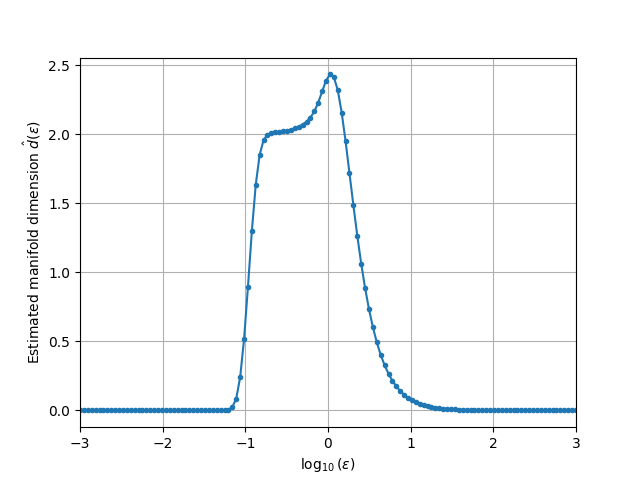

In [11]:
i_fig = 2

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_tuning(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_tuning(figspecs):
    fig, ax = figspecs    
    ax.plot(log10_bandwidths, est_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel('$\log_{10}(\epsilon)$')
    ax.set_ylabel('Estimated manifold dimension $\hat d(\epsilon)$');


plotfig_tuning(initfig_tuning(i_fig))

In [12]:
#bandwidth_scl = 0.5
#bandwidth = bandwidth_scl * bandwidth_opt
bandwidth = 0.5
dim = k_tune(jnp.log10(bandwidth))
rbf: Callable[[X, X], R] = knl.make_exponential_rbf(scl, bandwidth)
k: Callable[[X, X], R] = compose(rbf, sqdist)
p: Callable[[X, X], R] = knl.dm_normalize(ell2, '1', k)
t_heat = bandwidth**2 / 4.0
fourpi = 4.0 * jnp.pi
vol = knl.riemannian_vol(ell2, p, dim, t_heat, fourpi)
bandwidth_func: Callable[[X], R] = knl.make_bandwidth_function(ell2, k, dim, vol)
scaled_sqdist: Callable[[X, X], R] = knl.make_scaled_sqdist(ell2, sqdist,  
                                                            bandwidth_func)
vol_true = (2. * jnp.pi) ** 2 
print(f"Estimated dimension: {dim:.3e}")
print(f"True volume: {vol_true:.3e}")
print(f"Estimated volume: {vol:.3e}")

Estimated dimension: 2.072e+00
True volume: 3.948e+01
Estimated volume: 3.784e+01


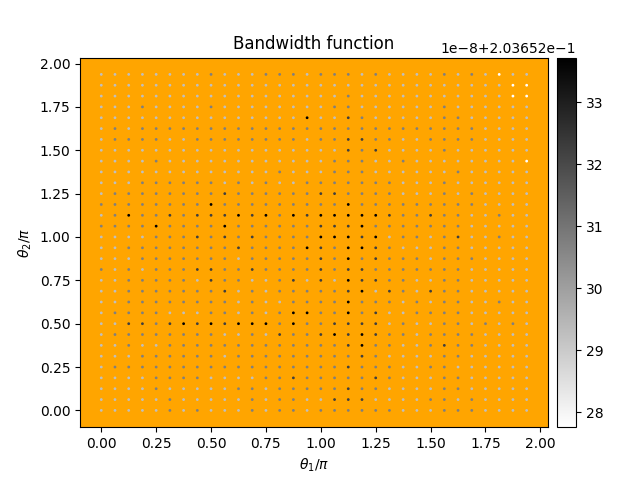

In [13]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_bandwidth(i):
    fig, ax = plt.subplots(num=i_fig)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="4%", pad="2%")
    return (fig, ax, cax)


def plotfig_bandwidth(figspecs):
    fig, ax, cax = figspecs    
    plt.rcParams['grid.color'] = "yellow"    
    bw_vals = jvmap(bandwidth_func)(xs)
    sc = ax.scatter(theta1s, theta2s, c=bw_vals, s=1, 
                    vmin=jnp.min(bw_vals), vmax=jnp.max(bw_vals),
                    cmap="binary")
    fig.colorbar(sc, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Bandwidth function")
    ax.set_facecolor('orange')
    plt.rcdefaults();


plotfig_bandwidth(initfig_bandwidth(i_fig))

In [14]:
make_shape_func = partial(knl.make_exponential_rbf, scl)

def k_vb_func(epsilon: R) -> Callable[[X, X], R]:
    return compose(make_shape_func(epsilon), scaled_sqdist)

start_time = time.perf_counter()
k_vb_tune = jit(knl.make_tuning_objective(ell2, k_vb_func, grad))
est_vb_dims = jnp.array([k_vb_tune(epsilon)
                         for epsilon in log10_bandwidths])
i_opt_vb = jnp.argmax(est_vb_dims)
vb_bandwidth_opt = 10. ** log10_bandwidths[i_opt_vb]
end_time = time.perf_counter()
print(f"VB kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt_vb}")
print(f"Optimal bandwidth: {vb_bandwidth_opt:.3e}")
print(f"Estimated dimension from optimal bandwidth: {est_vb_dims[i_opt_vb]:.3e}")

VB kernel tuning took 6.470e-01 s
Optimal bandwidth index: 79
Optimal bandwidth: 5.399e+00
Estimated dimension from optimal bandwidth: 2.435e+00


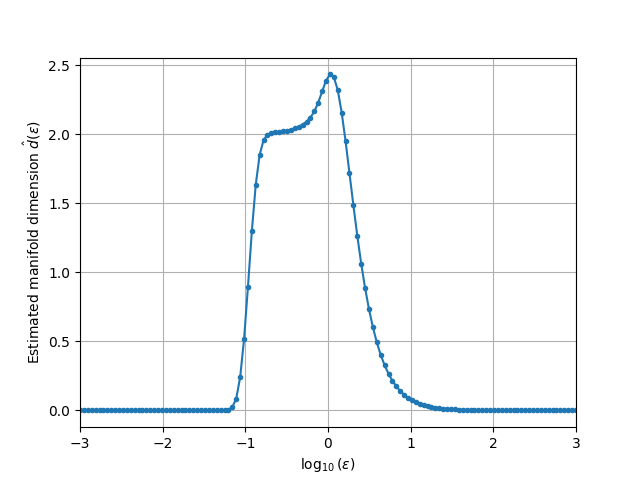

In [15]:
i_fig = 4
if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_vbtuning(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_vbtuning(figspecs):
    fig, ax = figspecs
    ax.plot(log10_bandwidths, est_vb_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel('$\log_{10}(\epsilon)$')
    ax.set_ylabel('Estimated manifold dimension $\hat d(\epsilon)$');


plotfig_tuning(initfig_tuning(i_fig))

In [16]:
#vb_bandwidth_scl = 0.5
#vb_bandwidth = vb_bandwidth_scl * vb_bandwidth_opt
vb_bandwidth = 0.5
rbf_vb: Callable[[X, X], R] = knl.make_exponential_rbf(scl, vb_bandwidth)
k_vb: Callable[[X, X], R] = compose(rbf_vb, scaled_sqdist)
k_bs: Callable[[X, X], R] = knl.bs_normalize(ell2, k_vb)
k_bs_transp = swap_args(k_bs)
k_bs_op: Callable[[V], F[X, R]] = knl.make_integral_operator(ell2, k_bs)
k_bs_transp_op: Callable[[V], F[X, R]] = \
    knl.make_integral_operator(ell2, k_bs_transp)
g_bs_op: F[V, V] = compose(inclusion_map, k_bs_op)
g_bs_transp_op: F[V, V] = compose(inclusion_map, k_bs_transp_op)
g_op: F[V, V] = compose(g_bs_op, g_bs_transp_op)
a = LinearOperator(shape=(n, n), dtype=r_dtype, matvec=jit(g_op))

#alpha: Alpha = '0.5'
#psym: Callable[[X, X], R] = dmsym_normalize(ell2, alpha, k_vb)
#psym_op: Callable[[V], F[X, R]] = make_integral_operator(ell2, psym)
#gsym_op: F[V, V] = compose(inclusion_map, psym_op)
#a = LinearOperator(shape=(n, n), dtype=dtype, matvec=jit(gsym_op))

In [17]:
m_eigs: int = 32
m: M = m_eigs

start_time = time.perf_counter()
unsorted_evals: Rm
unsorted_evecs: Vm
unsorted_evals, unsorted_evecs = eigsh(a, m_eigs, which='LA')
end_time = time.perf_counter()
print(f'Eigendecomposition took {end_time - start_time:.3e} s')

isort = jnp.argsort(unsorted_evals)
lambs = unsorted_evals[isort[::-1]]
etas = (1. - lambs) / vb_bandwidth**2 * 4.
us = unsorted_evecs[:, isort[::-1]]
phis = us * jnp.sqrt(float(n))
print('First 5 Laplacian eigenvalues:')
print(etas[0:5])

Eigendecomposition took 2.788e+00 s
First 5 Laplacian eigenvalues:
[2.8610229e-05 2.8783798e-02 2.8787613e-02 2.8800964e-02 2.8882980e-02]


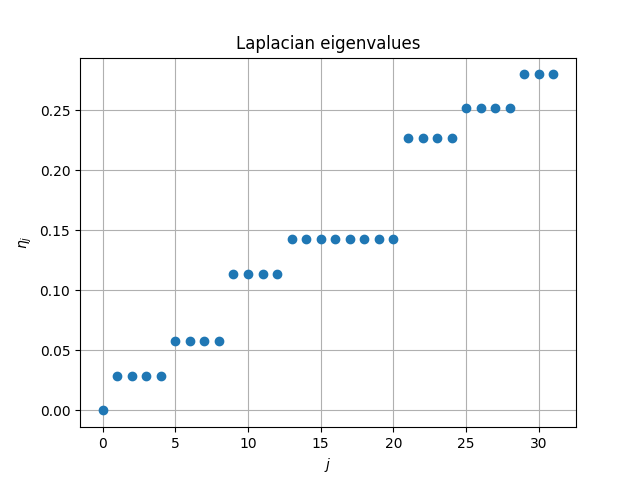

In [18]:
m_eig_plt = m_eigs
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

def initfig_vbtuning(i):
    fig, ax = plt.subplots(num=i_fig)
    return (fig, ax)


def plotfig_lapl_spec(figspecs):
    fig, ax = figspecs        
    ax.plot(jnp.arange(0, m_eig_plt), etas[0 : m_eig_plt], 'o')
    ax.grid()
    ax.set_xlabel('$j$')
    ax.set_ylabel('$\\eta_j$')
    ax.set_title('Laplacian eigenvalues');


plotfig_lapl_spec(initfig_tuning(i_fig))

interactive(children=(IntSlider(value=1, continuous_update=False, description='j', max=32), Output()), _dom_cl…

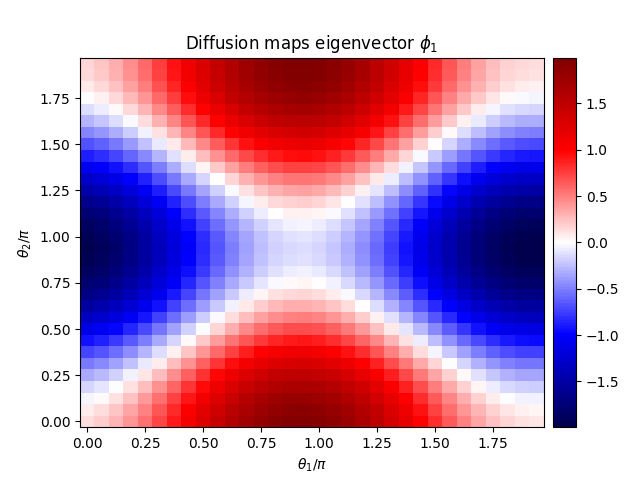

In [19]:
i_fig = 6

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_lapl_eigs(i):
    fig, ax = plt.subplots(num=i_fig)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    return (fig, ax, cax)

    
slider_lapl_eigs = IntSlider(value=1, min=0, max=m_eig_plt,
                             continuous_update=False)


@interact(j=slider_lapl_eigs, figspecs=fixed(initfig_lapl_eigs(i_fig))) 
def plotfig_lapl_eigs(j, figspecs):
    fig, ax, cax = figspecs
    a = jnp.max(jnp.abs(phis[:, j]))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(theta1s, theta2s, phis[:, j].reshape(n_grd, n_grd),
                        vmin=-a, vmax=a, cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f'Diffusion maps eigenvector $\\phi_{{{j}}}$') 

In [20]:
vb_bandwidth = 1.0
rbf_vb: Callable[[X, X], R] = knl.make_exponential_rbf(scl, vb_bandwidth)
k_vb: Callable[[X, X], R] = compose(rbf_vb, scaled_sqdist)
k_bs: Callable[[X, X], R] = knl.bs_normalize(ell2, k_vb)
k_bs_transp = swap_args(k_bs)
k_bs_op: Callable[[V], F[X, R]] = knl.make_integral_operator(ell2, k_bs)
k_bs_transp_op: Callable[[V], F[X, R]] = \
    knl.make_integral_operator(ell2, k_bs_transp)
g_bs_op: F[V, V] = compose(inclusion_map, k_bs_op)
g_bs_transp_op: F[V, V] = compose(inclusion_map, k_bs_transp_op)
g_op: F[V, V] = compose(g_bs_op, g_bs_transp_op)


@swap_args
def v_grad_k_bs(x: X, y: X) -> R:
    _, vgp = jvp(partial(k_bs_transp, x), (y,), (v(y),))
    return vgp


v_grad_k_op = compose(knl.make_integral_operator(ell2, v_grad_k_bs),
                      g_bs_transp_op)
v_grad_g_op = compose(inclusion_map, v_grad_k_op)
v_reg_op = compose(g_op, v_grad_g_op)
a2 = LinearOperator(shape=(n, n), dtype=c_dtype, matvec=jit(v_reg_op))

In [21]:
sort_by: Literal['Frequency', 'Energy'] = 'Frequency'
m_eigs_v: int = 100
m_v: M = m_eigs_v

start_time = time.perf_counter()
unsorted_omegas: Rm
unsorted_zetas: Vm
unsorted_omegas, unsorted_zetas = eigs(a2, m_eigs_v, which='LI')
end_time = time.perf_counter()
print(f'Generator eigendecomposition took {end_time - start_time:.3e} s')

Generator eigendecomposition took 6.350e+00 s


In [22]:
isort_omegas = jnp.argsort(unsorted_omegas.imag[::-1])
omegas = unsorted_omegas[isort_omegas[0 : m_v]].imag
zetas = unsorted_zetas[:, isort_omegas[0 : m_v]] * jnp.sqrt(float(n))
#omegas = unsorted_omegas[0 : m_v].imag
#zetas = unsorted_zetas[:, 0 : m_v] * jnp.sqrt(float(n))
print('5 Largest eigenfrequencies:')
print(omegas[0 : 5])

5 Largest eigenfrequencies:
[11.447701 11.251724 11.188082 10.238823 10.328793]


interactive(children=(IntSlider(value=7, continuous_update=False, description='j'), Output()), _dom_classes=('…

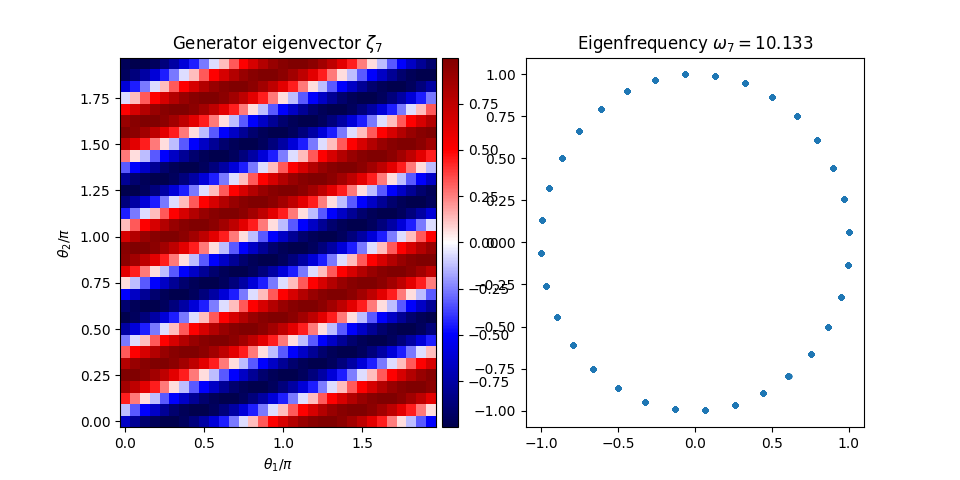

In [24]:
i_fig = 7

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_gen_eigs(i):
    fig = plt.figure(num=i_fig, figsize=plt.figaspect(0.5))
    axs = [fig.add_subplot(1, 2, i + 1) for i in range(2)]
    ax_divider = make_axes_locatable(axs[0])
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    return (fig, axs, cax)


slider_gen_eigs = IntSlider(value=7, min=0, max=m_v, continuous_update=False)


@interact(j=slider_gen_eigs, figspecs=fixed(initfig_gen_eigs(i_fig))) 
def plotfig_gen_eigs(j, figspecs):
    fig, axs, cax = figspecs
    [ax.cla() for ax in axs]
    cax.cla()
    a = jnp.max(jnp.abs(zetas[:, j].real))
    im = axs[0].pcolormesh(theta1s, theta2s, zetas[:, j].reshape(n_grd, n_grd).real,
                          vmin=-a, vmax=a, cmap="seismic")
    cb = fig.colorbar(im, cax=cax)
    axs[0].set_xlabel('$\\theta_1/\\pi$')
    axs[0].set_ylabel('$\\theta_2/\\pi$')
    axs[0].set_title(f'Generator eigenvector $\\zeta_{{{j}}}$')
    axs[1].plot(zetas[:, j].real, zetas[:, j].imag, '.')
    axs[1].set_title(f'Eigenfrequency $\\omega_{{{j}}}={omegas[j]:.3f}$') 